In [35]:
import time
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

%pylab inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

Populating the interactive namespace from numpy and matplotlib


# Outline

---

- Explore
    - Plot the data
    - Clean outliers
    - Impute missing values if needed

- Transform
    - Take the natural log if needed

- Decompose your data
    - Check if the time-series has any **overall trend** or **seasonality**?
    - Plot the decomposed series
    - If you're fitting an ARIMA model, remove seasonality.

- Check for Stationarity and find $d$
    - Is the series stationary?
    - Run the Augmented Dickey Fuller test, 
    - Check ACF & PACF plots to 
    - Determine **order of differencing** needed to stationarize the series

- Autocorrelations and find $p, q$
    - Choose $p, q$ of the ARIMA by examining ACF and PACF plots

- Fit ARIMA/SARIMAX model over a grid
    - Use pdq and set up a grid search
    - Find the best model using
        - AIC/BIC
        - Out of Sample Prediction Error
    - Check your Residuals, they should be ~$N(0, 1)$ and look like white noise

- Make predictions

----

- Note that ARIMA models assume non-seasonal series,
    - need to de-seasonalize the series before modeling


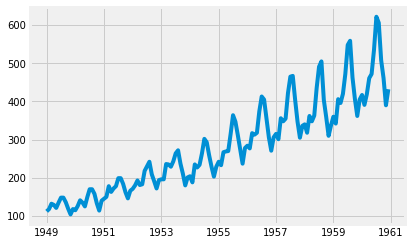

In [12]:
df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/AirPassengers.csv")

y = pd.Series(data=df['value'].values, 
              index=pd.date_range(start='1949-01-01', periods=len(df), freq='MS'))
y.plot();

## Split the data

In [14]:
split_pt = int(len(y) * 0.7)

tr = y.iloc[:split_pt]
te = y.iloc[split_pt:]

print(len(tr), len(te))

100 44


## Grid Search

**Considerations when setting up the parameter grid**

- If your ts is stationary, use d = 0
- If your ts is not stationary, first figure out the value of d using ACF, PACF plots
- Do you need to use `log(y)`

----

In [17]:
p = q = d = range(2)
pdq = list(itertools.product(p, d, q))
PDQ = [tuple(list(x) + [12]) for x in pdq]
pdqPDQs = list(itertools.product(pdq, PDQ))

errors = []
results = {}

print("Searching through {} parameter combinations.".format(len(pdqPDQs)))

t0 = time.time()
for i, order in enumerate(pdqPDQs):
    """
    """
    
    try:
        model = SARIMAX(tr, order=order[0], seasonal_order=order[1]).fit()
        results[order] = model.aic
    except:
        errors.append(order)
        
print("Search completed in {} seconds".format(round(time.time() - t0, 2)))
print("{} errors were suppressed.".format(len(errors)))

Searching through 64 parameter combinations.
Search completed in 4.3 seconds
26 errors were suppressed.


## The best model

In [20]:
best_params = pd.Series(results).sort_values().reset_index().iloc[0].iloc[:2]
best_params.index = ['pdq', 'PDQs']
print("Fitting the best model using the params \n(p, d, q) = {} and \n(P, D, Q, s) = {}\n\n".format(best_params['pdq'], best_params['PDQs']))

best_model = SARIMAX(tr, order=best_params['pdq'], seasonal_order=best_params['PDQs']).fit()
print(best_model.summary())

Fitting the best model using the params 
(p, d, q) = (1, 1, 0) and 
(P, D, Q, s) = (1, 1, 0, 12)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Wed, 23 May 2018   AIC                            644.203
Time:                                    16:29:15   BIC                            652.018
Sample:                                01-01-1949   HQIC                           647.366
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -

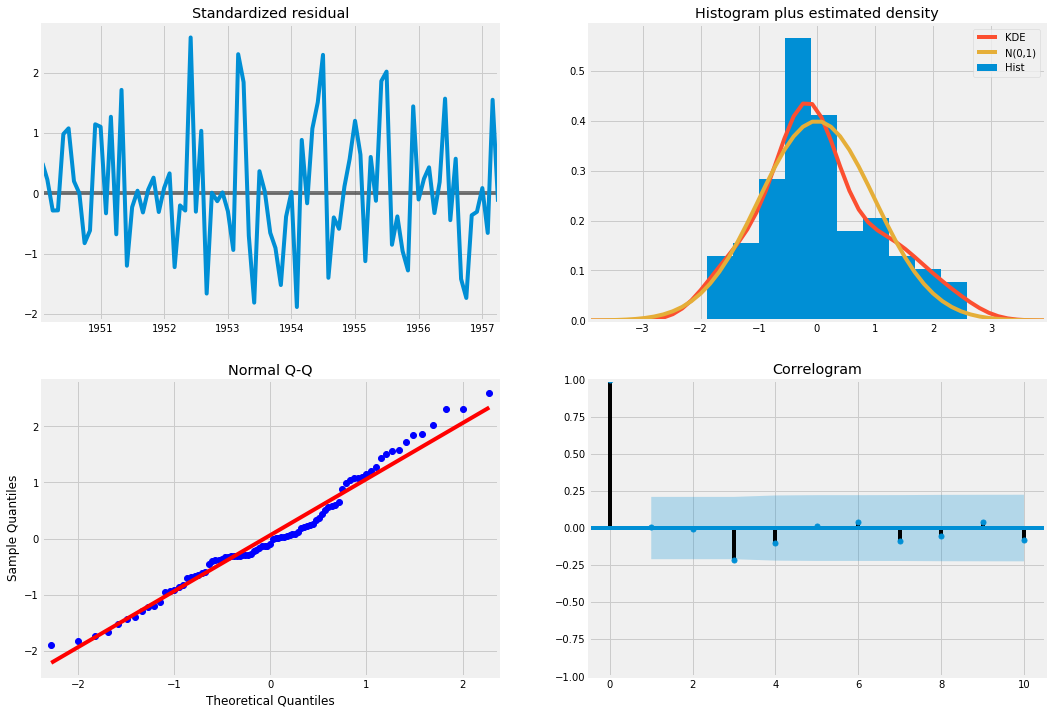

In [21]:
best_model.plot_diagnostics(figsize=(16, 12));

## Train Error

In [23]:
split = int(0.2 * len(tr))

# predict on the last 20 values of the training period
# these are one-step-ahead
yhat_tr = best_model.get_prediction(start=tr.index.tolist()[-split], dynamic=False)

yhat_tr_ci = yhat_tr.conf_int()
yhat_mean_tr = yhat_tr.predicted_mean
yhat_mean_tr.name = 'mean_value_tr'

mse_tr = mean_squared_error(y_true=tr[-split:], y_pred=yhat_mean_tr)
print("The train error is {}.".format(round(mse_tr, 4)))

The train error is 72.8372.


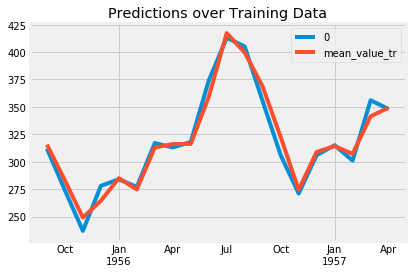

In [24]:
pd.concat([tr[-split:], yhat_mean_tr], axis=1).plot(title="Predictions over Training Data");

### Out - of - Sample Prediction

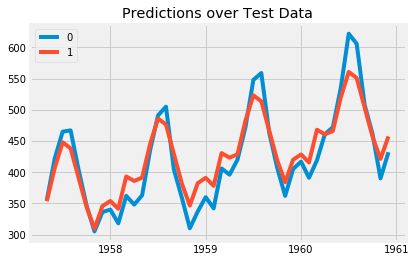

In [25]:
yhat_oos = best_model.get_forecast(steps=len(te))

yhat_oos_mean = yhat_oos.predicted_mean
yhat_oos_cnfi = yhat_oos.conf_int()

pd.concat([te, yhat_oos_mean], axis=1).dropna().plot(title='Predictions over Test Data');

In [27]:
mse_te = mean_squared_error(te, yhat_oos_mean)
print("The test error is {}".format(round(mse_te, 2)))

The test error is 686.75


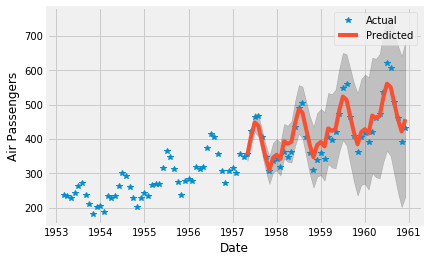

In [28]:
ax = y[50:].plot.line(label='Actual', style='*')
yhat_oos_mean.plot(ax=ax, label='Predicted')
ax.fill_between(yhat_oos_cnfi.index, 
                yhat_oos_cnfi.iloc[:, 0], 
                yhat_oos_cnfi.iloc[:, 1], color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Air Passengers')

plt.legend()
plt.show()